# Section 1: Setup

In [22]:
# Package of standard importing that I use recorrently

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import auc, roc_auc_score, roc_curve

%matplotlib inline

# Dataset reading

baseChurn = pd.read_csv('/content/BankChurners.csv')

# Section 2: Data Understanding

In this project I will deepen my understanding about my client, as well as what motivates their churn. Below, I list some of the main issues that are important to me.

* Question 1: Which customer education level is most likely to Churn?

* Question 2: What is the median total transaction value of customers who churn?

* Question 3: Which two variables have the greatest correlation?

* Question 4: What is the variable that most influences the Churn probability?


In [23]:
# First of all, I need to remove the last two columns because the owner of the dataset
# suggest the users to do that

baseChurn = baseChurn.iloc[:,:-2]

In [24]:
# Let's check the variables types and take a look in a part of the dataset

print(baseChurn.dtypes)

baseChurn.head(5)

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [25]:
# As the first (target) variable name is uppercase, I'll rename it in order to improve the design

baseChurn = baseChurn.rename(columns={'CLIENTNUM':'customerID'})

In [26]:
# I'm going to take another look in the dataset, but now looking for missing values

baseChurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customerID                10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [27]:
# I print the count of unique values from categorical variables

for col in baseChurn.columns[1:]:
    if baseChurn[col].dtype == 'object':
        print(col,baseChurn[col].nunique())

Attrition_Flag 2
Gender 2
Education_Level 7
Marital_Status 4
Income_Category 6
Card_Category 4


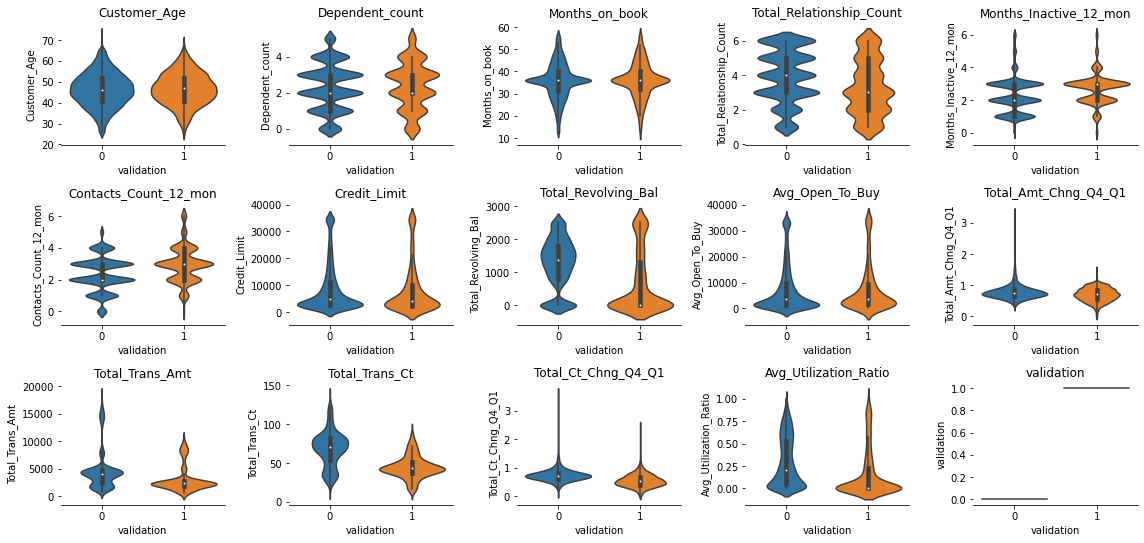

In [28]:
# In this step, I'll plot many violin plots to better understand 
# the distribution of data on each numeric variable

histogram = baseChurn.copy()

del histogram['customerID']

histogram['validation'] = 0

histogram.loc[histogram.Attrition_Flag == 'Existing Customer', 'validation'] = 0
histogram.loc[histogram.Attrition_Flag == 'Attrited Customer', 'validation'] = 1 # Churn

del histogram['Attrition_Flag']

histogram = histogram.select_dtypes(['number'])

fig = plt.figure(figsize=(16,16)) # Figure size to plot

for i in range(histogram.shape[1]):
    plt.subplot(6, 5, i + 1)
    f = plt.gca()
    f.set_title(histogram.columns.values[i])
    sns.violinplot(data=histogram, x='validation', y=histogram.columns[i])
    sns.despine(left=True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

histogram_backup = histogram.copy()
histogram_backup['Attrition_Flag'] = baseChurn['Attrition_Flag']

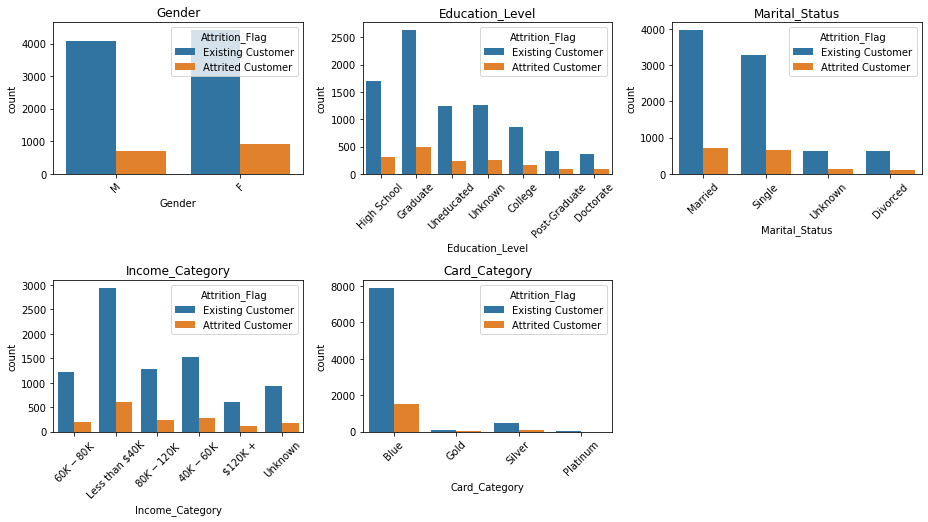

In [29]:
# In this step, I will plot vertical bars for each categorical 
# variable with a focus on churn segmentation

categVariables = baseChurn.copy()

categVariables = categVariables.select_dtypes(['object'])

categVariables['customerID'] = baseChurn['customerID']

c=1

fig = plt.figure(figsize=(13,8)) # Figure size to plot

for i in categVariables:
  if (i != 'Attrition_Flag' and i != 'customerID'):
    plt.subplot(2, 3, c)
    plotCategVar = pd.DataFrame()
    plotCategVar = baseChurn[['customerID','Attrition_Flag',i]]
    f = plt.gca()
    f.set_title(i)
    sns.countplot(data=plotCategVar, x = i, hue = 'Attrition_Flag')
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    c+=1

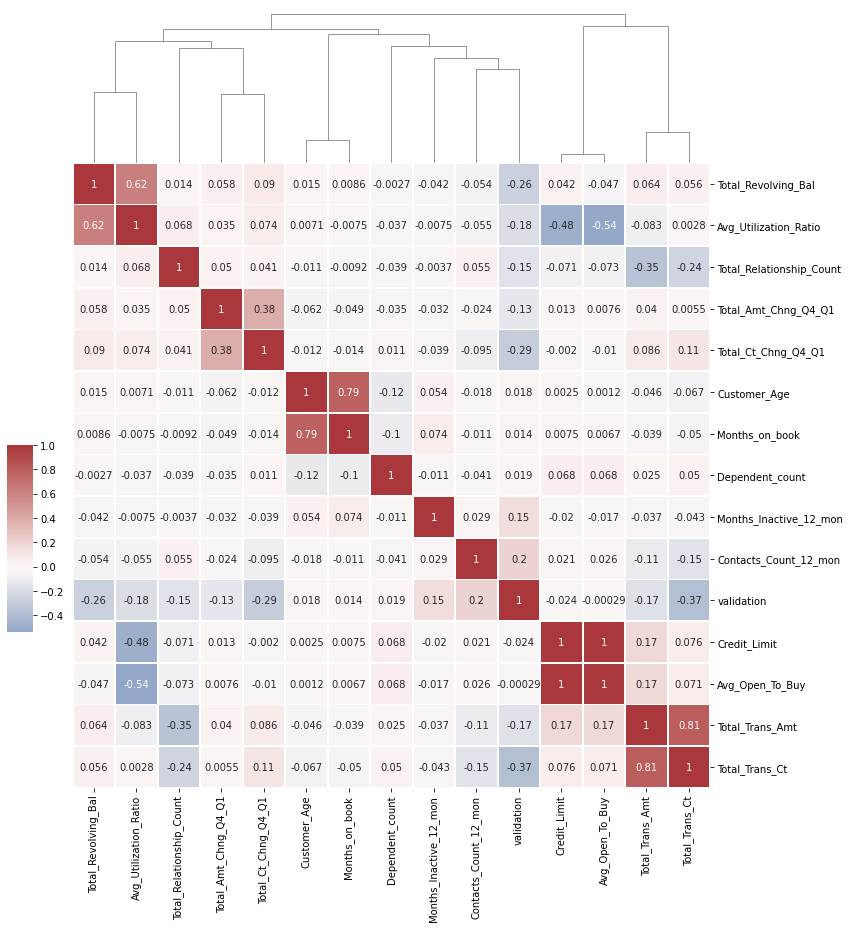

In [30]:
# The idea here is find out the correlation between the numeric variables

import numpy as np

corrMatrix = histogram

g = sns.clustermap(corrMatrix.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13), annot=True)

g.ax_row_dendrogram.remove()

# Section 3: Data Preparation

In [31]:
# I write a function to detect the multicollinearity of the dataset variables

def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [32]:
# I apply the function on my dataset

analysisVIF = baseChurn.select_dtypes(['number']).drop(columns=['customerID'])

calc_vif(analysisVIF).sort_values(by='VIF', ascending=False).head(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
6,Credit_Limit,inf
7,Total_Revolving_Bal,inf
8,Avg_Open_To_Buy,inf
0,Customer_Age,75.090540
2,Months_on_book,56.437261


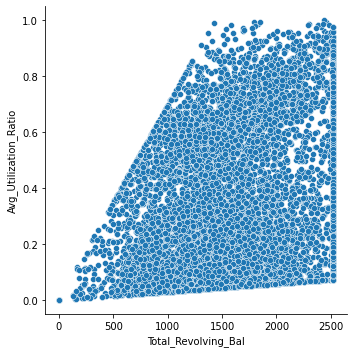

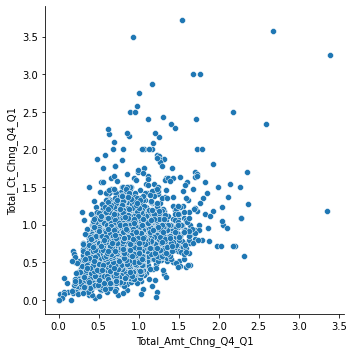

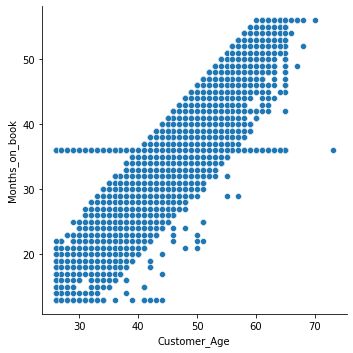

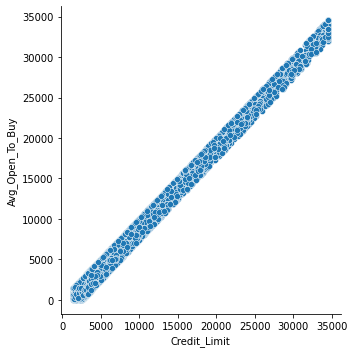

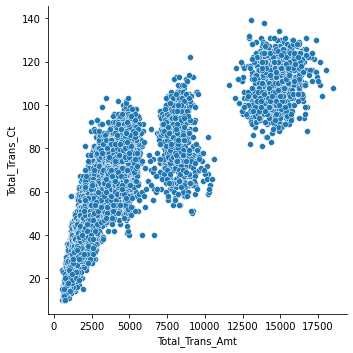

In [33]:
# I already knew before the previous step that many variables would 
# have a high multicollinearity because in the cluster map it was very visible.

# The VIF function helped me to confirm my first suspicion.

# Now, as I know which variables I need to look closest, I'll do that.

groupColumns = [['Total_Revolving_Bal','Avg_Utilization_Ratio']
               ,['Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1']
               ,['Customer_Age','Months_on_book']
               ,['Credit_Limit','Avg_Open_To_Buy']
               ,['Total_Trans_Amt','Total_Trans_Ct']]

for i in range(len(groupColumns)):
  col1 = groupColumns[i][0]
  col2 = groupColumns[i][1]
  sns.relplot(x=analysisVIF[col1], y=analysisVIF[col2])

plt.show()

In [34]:
# After looking at the data, I already know which ones I'll delete 
# from my dataset to solve the high multicollinearity problem.

del analysisVIF['Avg_Utilization_Ratio']
del analysisVIF['Total_Ct_Chng_Q4_Q1']
del analysisVIF['Months_on_book']
del analysisVIF['Avg_Open_To_Buy']
del analysisVIF['Total_Trans_Ct']

calc_vif(analysisVIF).sort_values(by='VIF', ascending=False).head(5)

,variables,VIF
0,Customer_Age,17.720704
7,Total_Amt_Chng_Q4_Q1,10.952239
2,Total_Relationship_Count,7.115694
3,Months_Inactive_12_mon,6.031580
4,Contacts_Count_12_mon,5.532626


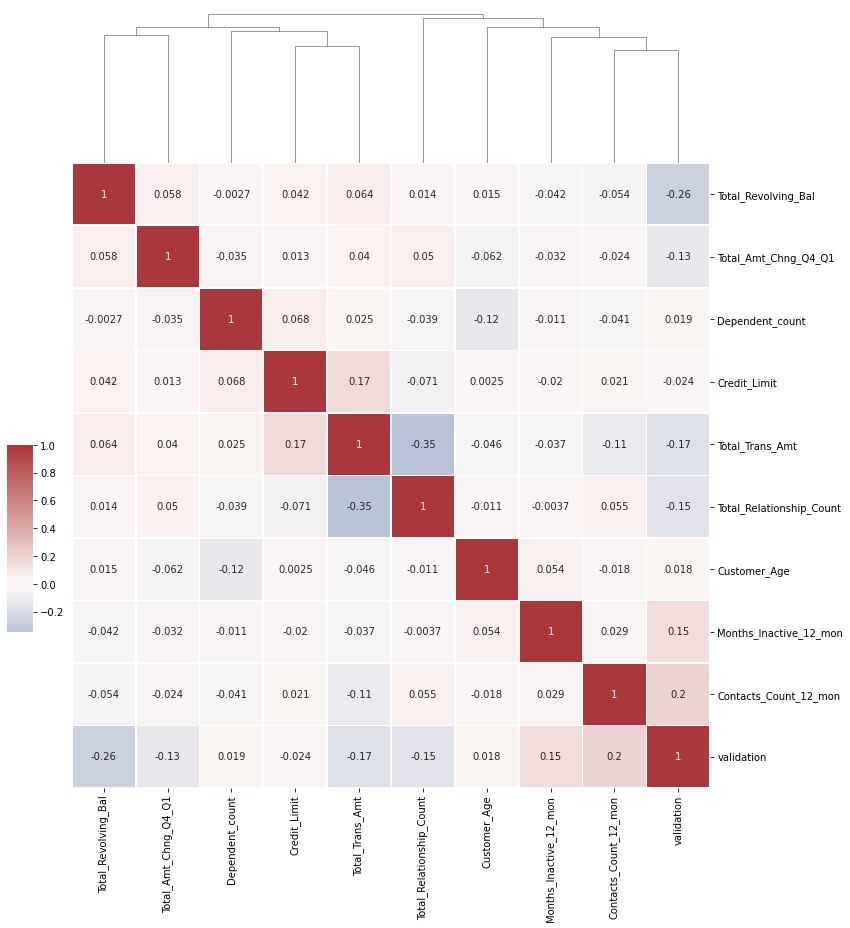

In [35]:
# Another check of the correlation between variables after preparation 

corrMatrix = histogram

del corrMatrix['Avg_Utilization_Ratio']
del corrMatrix['Total_Ct_Chng_Q4_Q1']
del corrMatrix['Months_on_book']
del corrMatrix['Avg_Open_To_Buy']
del corrMatrix['Total_Trans_Ct']

g = sns.clustermap(corrMatrix.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13), annot=True)

g.ax_row_dendrogram.remove()

# Section 4: Analysis / Modeling

In [36]:
# I start here the steps related to the preparation of the data for the statistical modeling

baseChurn['Churn'] = 0

baseChurn.loc[baseChurn.Attrition_Flag == 'Existing Customer', 'Churn'] = 0
baseChurn.loc[baseChurn.Attrition_Flag == 'Attrited Customer', 'Churn'] = 1 # Churn

del baseChurn['Attrition_Flag']
del baseChurn['Avg_Utilization_Ratio']
del baseChurn['Total_Ct_Chng_Q4_Q1']
del baseChurn['Months_on_book']
del baseChurn['Avg_Open_To_Buy']
del baseChurn['Total_Trans_Ct']

identity = baseChurn['customerID']
baseChurn = baseChurn.drop(columns='customerID')

# I use the get dummies here to convert categorical variable into indicator variables

baseChurn= pd.get_dummies(baseChurn)

baseChurn = pd.concat([baseChurn, identity], axis = 1)

In [37]:
# I separate the target variable from the rest of the dataset

target = baseChurn['Churn']

baseChurn = baseChurn.drop(columns='Churn')

In [38]:
# Here, the dataset is divided between training and test according to the parameters used

X_train, X_test, y_train, y_test = train_test_split(baseChurn, target, stratify=target, test_size = 0.2, random_state = 0)

train_identity = X_train['customerID']
X_train = X_train.drop(columns = ['customerID'])

test_identity = X_test['customerID']
X_test = X_test.drop(columns = ['customerID'])

In [39]:
# Normalization of the dataset

sc_X = StandardScaler()

X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

# Section 5: Evaluation

In this section I answer the questions that were proposed in Section 2 (Data Understanding). After answering these questions I continue to build the model.

* Question 1: Which customer education level is most likely to Churn?

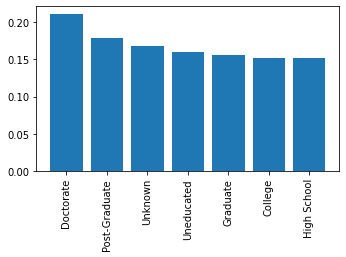

In [40]:
fig = plt.figure(figsize=(5,4))

plotCategVar = pd.DataFrame()
plotCategVar = categVariables[['customerID','Attrition_Flag','Education_Level']]
plotCategVar = pd.crosstab(plotCategVar['Education_Level'],
                           plotCategVar['Attrition_Flag']).apply(lambda r: r/r.sum(), axis=1)
plotCategVar = plotCategVar.reset_index(drop=False).sort_values(by='Attrited Customer',ascending=False)

plt.bar(plotCategVar['Education_Level'],plotCategVar['Attrited Customer'])
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

* Question 2: What is the median total transaction value of customers who churn?

Median Total Transaction: 2329.00


<Figure size 360x288 with 0 Axes>

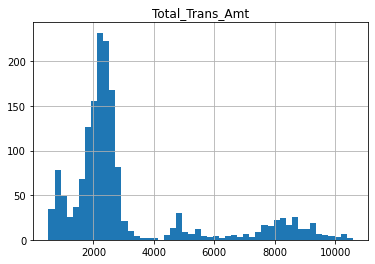

In [41]:
fig = plt.figure(figsize=(5,4))

histogram_backup[histogram_backup['Attrition_Flag']=='Attrited Customer'].hist('Total_Trans_Amt', bins=50)

print('Median Total Transaction: {0:.2f}'.format(histogram_backup['Total_Trans_Amt']
                                                  [histogram_backup['Attrition_Flag']=='Attrited Customer'].median()))

* Question 3: Which two variables have the greatest correlation?

In [42]:
max_corr = histogram_backup.corr().abs()

max_corr = max_corr.unstack()
max_corr = max_corr.sort_values(kind="quicksort", ascending=False)
max_corr = max_corr.reset_index(drop=False)

max_corr[max_corr['level_0'] != max_corr['level_1']].sort_values(by=0, ascending=False).iloc[0]

level_0       Credit_Limit
level_1    Avg_Open_To_Buy
0                 0.995981
Name: 15, dtype: object

In [43]:
# I chose to use logistic regression because I understand this kind of model is useful in this situation

classifier = LogisticRegression(random_state = 0, penalty = 'l2')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracies = cross_val_score(estimator = classifier,X = X_train, y = y_train, cv = 10)
print("Logistic Regression Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(),
accuracies.std()*2))

Logistic Regression Classifier Accuracy: 0.87 (+/- 0.01)


Text(0.5, 15.0, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

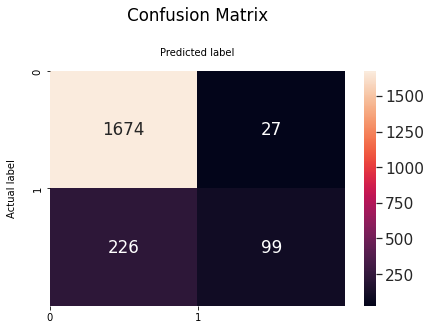

In [44]:
# Creating a Confusion Matrix

cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion Matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

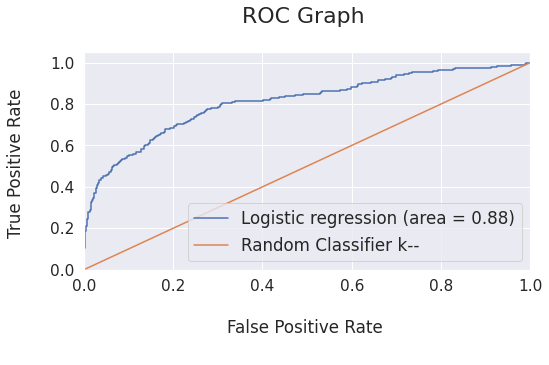

In [45]:
# Evaluating the model using ROC Graph

classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 4))

plt.plot(rf_fpr, rf_tpr, 
label='Logistic regression (area = %0.2f)' % classifier_roc_auc)

plt.plot([0,1], [0,1],label='Random Classifier ' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

plt.show()

In [46]:
# Creating a table with the feature importances

feature_importances = pd.concat([
pd.DataFrame(baseChurn.drop(columns='customerID').
columns, columns = ['variables']),
pd.DataFrame(np.transpose(classifier.coef_), 
columns = ["coef"])],axis = 1)
featImport = feature_importances.sort_values("coef", ascending = False)

* Question 4: What is the variable that most influences the Churn probability?

The variable that most influences the Churn probability is: Total_Trans_Amt 



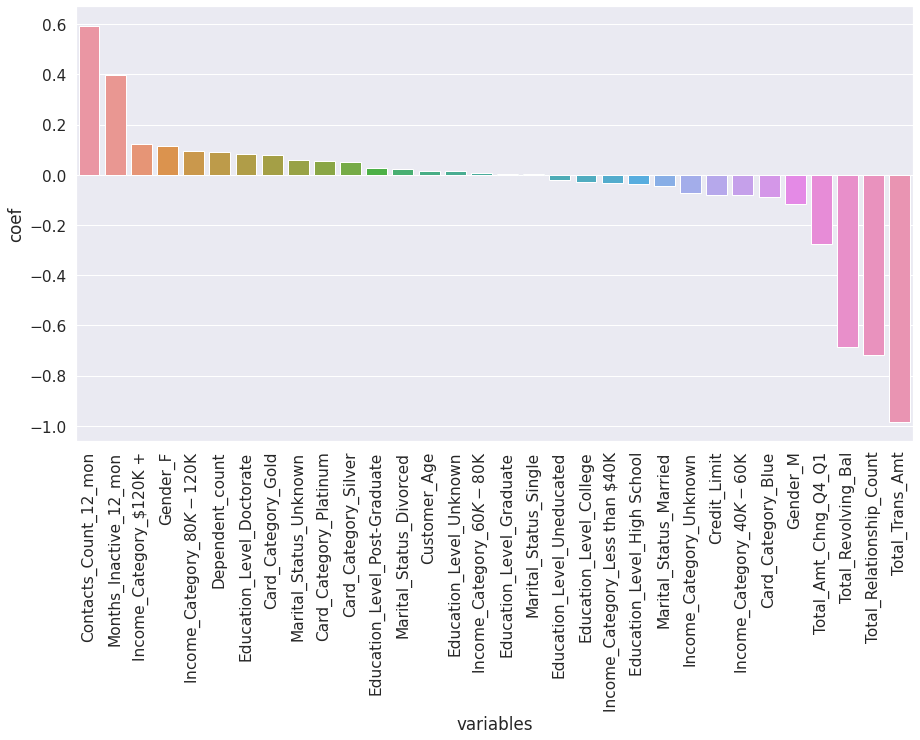

In [47]:
# I plot the above result in this step

fig = plt.figure(figsize=(15, 8))

t = sns.barplot(x=featImport.iloc[:,0], y=featImport.iloc[:,1])
plt.xticks(rotation=90)

varAnswer = featImport['variables'][featImport.iloc[:,1].abs() == featImport.iloc[:,1].abs().max()]

print('The variable that most influences the Churn probability is: {} \n'.format(varAnswer.iloc[0]))

In [48]:
# I apply adjusting techniques in order to reduce the overfit of the model

# When training a model, the model must find a weight for each feature.
# Each weight is a value in the theta vector. As there is now a penalty on 
# having a weight for a feature, this encourages the model to move 
# the weights closer to 0 for some features.
# Therefore, a regularization minimizes the complexity of a model to avoid overfitting.

# First try:

penalty = ['l1', 'l2'] 

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)

lr_classifier  = lr_classifier .fit(X_train, y_train)
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

(0.6575825285438619, {'C': 10, 'penalty': 'l2'})

In [49]:
# Second try:

penalty = ['l2']

C = [ 0.0001, 0.001, 0.01, 0.02, 0.05]

parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)
lr_classifier  = lr_classifier .fit(X_train, y_train)
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

(0.6531259474326867, {'C': 0.05, 'penalty': 'l2'})

In [50]:
# I could visualize the l2 was the best hyperparameter

lr_classifier = LogisticRegression(random_state = 0, penalty = 'l2')

lr_classifier.fit(X_train, y_train)

y_pred = lr_classifier.predict(X_test)

# Score of the probabilities

y_pred_probs = lr_classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1]

# Section 6: Results (Final Step)

In [51]:
# Here I predict the churn probability for each customer

final_results = pd.concat([test_identity, y_test], axis = 1).dropna()
final_results['predictions'] = y_pred
final_results['probChurn'] = y_pred_probs
final_results['probChurn'] = final_results['probChurn']*100
final_results['probChurn']=final_results['probChurn'].round(2)
final_results = final_results[['customerID', 'Churn', 'predictions', 'probChurn']]
final_results ['Ranking'] = pd.qcut(final_results['probChurn'].rank(method = 'first'),10,labels=range(10,0,-1))
print(final_results.sort_values(by='probChurn', ascending=False))

      customerID  Churn  predictions  probChurn Ranking
4184   803796708      1            1      96.27       1
3788   713730933      1            1      93.60       1
3983   708834483      1            1      91.76       1
3718   719770158      1            1      89.38       1
5925   809849358      1            1      88.76       1
...          ...    ...          ...        ...     ...
9835   716151858      0            0       0.10      10
9825   721438233      0            0       0.09      10
9841   715601808      0            0       0.08      10
9814   718805733      0            0       0.08      10
9819   716894658      0            0       0.07      10

[2026 rows x 5 columns]


(array([1111.,  397.,  199.,  100.,   79.,   49.,   36.,   25.,   20.,
          10.]),
 array([7.000e-02, 9.690e+00, 1.931e+01, 2.893e+01, 3.855e+01, 4.817e+01,
        5.779e+01, 6.741e+01, 7.703e+01, 8.665e+01, 9.627e+01]),
 <a list of 10 Patch objects>)

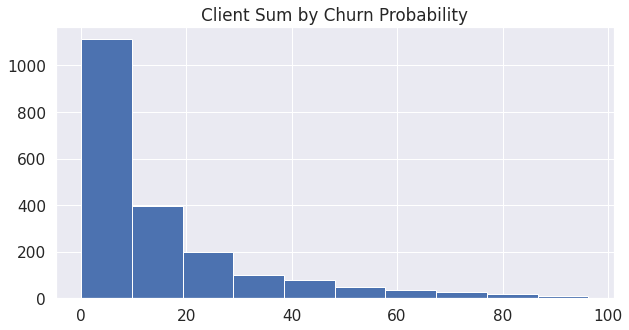

In [52]:
# And here I end my presentation with a graph that contains the above data

fig = plt.figure(figsize=(10,5))

plt.title('Client Sum by Churn Probability')
plt.hist(x=final_results['probChurn'], bins=10)

In [53]:
final_results.loc[final_results.probChurn <= 100, 'Range'] = '90-100'
final_results.loc[final_results.probChurn <= 90, 'Range']  = '80-90'
final_results.loc[final_results.probChurn <= 80, 'Range']  = '70-80'
final_results.loc[final_results.probChurn <= 70, 'Range']  = '60-70'
final_results.loc[final_results.probChurn <= 60, 'Range']  = '50-60'
final_results.loc[final_results.probChurn <= 50, 'Range']  = '40-50'
final_results.loc[final_results.probChurn <= 40, 'Range']  = '30-40'
final_results.loc[final_results.probChurn <= 30, 'Range']  = '20-30'
final_results.loc[final_results.probChurn <= 20, 'Range']  = '10-20'
final_results.loc[final_results.probChurn <= 10, 'Range']  = '0-10'

final_results = final_results.groupby(['Range'])['customerID'].count()

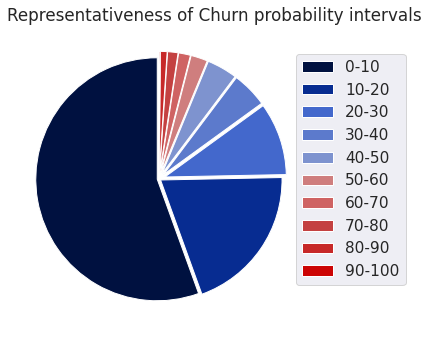

In [54]:
fig1, ax1 = plt.subplots(figsize=(10, 5))

explode = (0.015, 0.015, 0.05, 0.05, 0.05,
           0.05, 0.05, 0.05, 0.05, 0.05)
colors = ['#001140','#072c91','#4368cc','#5c7acc','#7e93cf',
          '#cf7e7e','#cf6363','#c44141','#c72828','#cc0404']

ax1.pie(final_results.tolist(), explode=explode, startangle=90, colors=colors)

ax1.legend(final_results.index.tolist(), loc=(0.95, 0.15))
ax1.set_title('Representativeness of Churn probability intervals', loc='left')
plt.tight_layout()
plt.show()